In [173]:
#Disable warnings
import shutup
shutup.please()

In [241]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.inspection import PartialDependenceDisplay
import PyALE

import shap
shap.initjs()

In [175]:
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay

In [176]:
# adapt PyALE.ale function to incorporate classification models (target in PyALE, can learn if want to learn programming)
# reference: https://htmlpreview.github.io/?https://github.com/DanaJomar/PyALE/blob/master/examples/ALE%20plots%20for%20classification%20models.html
def ale(target=None, print_meanres=False, **kwargs):
    if target is not None:
        class clf():
            def __init__(self, classifier):
                self.classifier = classifier
            def predict(self, X):
                return(self.classifier.predict_proba(X)[:, target])
        clf_dummy = clf(kwargs["model"])
        kwargs["model"] = clf_dummy
    if (print_meanres & len(kwargs["feature"])==1):
        mean_response = np.mean(kwargs["model"].predict(kwargs["X"]), axis=0)
        print(f"Mean response: {mean_response:.5f}")
    return PyALE.ale(**kwargs)

In [177]:
#Load data
train = pd.read_csv("MyProject\Data\churn_train.csv")
test = pd.read_csv("MyProject\Data\churn_test.csv")

## Data Explopration

In [178]:
train.sample(5)

state  account_length      area_code international_plan voice_mail_plan  \
416     NM              80  area_code_510                 no              no   
646     MA             127  area_code_408                yes              no   
1772    NE             105  area_code_408                 no              no   
3941    IL              74  area_code_408                 no              no   
1103    TX              82  area_code_415                 no              no   

      number_vmail_messages  total_day_minutes  total_day_calls  \
416                       0              206.3               97   
646                       0              176.9              110   
1772                      0              162.3               99   
3941                      0              141.9              103   
1103                      0              189.2               81   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
416              35.07              154.9               98             13.17   
646              30.07              167.9              100             14.27   
1772             27.59              212.5               95             18.06   
3941             24.12              201.0              110             17.09   
1103             32.16              184.4              117             15.67   

      total_night_minutes  total_night_calls  total_night_charge  \
416                 263.6                 82               11.86   
646                 182.2                138                8.20   
1772                214.7                114                9.66   
3941                211.2                117                9.50   
1103                255.8                 83               11.51   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
416                 12.4                12               3.35   
646                  7.7                 2               2.08   
1772                11.1                 8               3.00   
3941                10.9                11               2.94   
1103                10.6                 5               2.86   

      number_customer_service_calls churn  
416                               0    no  
646                               1   yes  
1772                              4    no  
3941                              1    no  
1103                              3   yes

In [179]:
train.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

In [180]:
train.isnull().sum().sum()

0

In [181]:
train.shape

(4250, 20)

In [182]:
train[train.churn=='no']

state  account_length      area_code international_plan voice_mail_plan  \
0       OH             107  area_code_415                 no             yes   
1       NJ             137  area_code_415                 no              no   
2       OH              84  area_code_408                yes              no   
3       OK              75  area_code_415                yes              no   
4       MA             121  area_code_510                 no             yes   
...    ...             ...            ...                ...             ...   
4245    MT              83  area_code_415                 no              no   
4246    WV              73  area_code_408                 no              no   
4247    NC              75  area_code_408                 no              no   
4248    HI              50  area_code_408                 no             yes   
4249    VT              86  area_code_415                 no             yes   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                        26              161.6              123   
1                         0              243.4              114   
2                         0              299.4               71   
3                         0              166.7              113   
4                        24              218.2               88   
...                     ...                ...              ...   
4245                      0              188.3               70   
4246                      0              177.9               89   
4247                      0              170.7              101   
4248                     40              235.7              127   
4249                     34              129.4              102   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0                27.47              195.5              103             16.62   
1                41.38              121.2              110             10.30   
2                50.90               61.9               88              5.26   
3                28.34              148.3              122             12.61   
4                37.09              348.5              108             29.62   
...                ...                ...              ...               ...   
4245             32.01              243.8               88             20.72   
4246             30.24              131.2               82             11.15   
4247             29.02              193.1              126             16.41   
4248             40.07              223.0              126             18.96   
4249             22.00              267.1              104             22.70   

      total_night_minutes  total_night_calls  total_night_charge  \
0                   254.4                103               11.45   
1                   162.6                104                7.32   
2                   196.9                 89                8.86   
3                   186.9                121                8.41   
4                   212.6                118                9.57   
...                   ...                ...                 ...   
4245                213.7                 79                9.62   
4246                186.2                 89                8.38   
4247                129.1                104                5.81   
4248                297.5                116               13.39   
4249                154.8                100                6.97   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0                   13.7                 3               3.70   
1                   12.2                 5               3.29   
2                    6.6                 7               1.78   
3                   10.1                 3               2.73   
4                    7.5                 7               2.03   
...                  ...               ...                ...   
4245  

In [183]:
train.shape[0], train.shape[1]

(4250, 20)

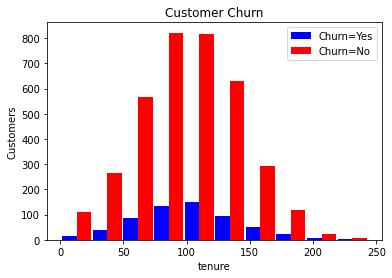

In [184]:
tenure_churn_no = train[train.churn=='no'].account_length
tenure_churn_yes = train[train.churn=='yes'].account_length

plt.xlabel("tenure")
plt.ylabel("Customers")
plt.title("Customer Churn")


plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['blue','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

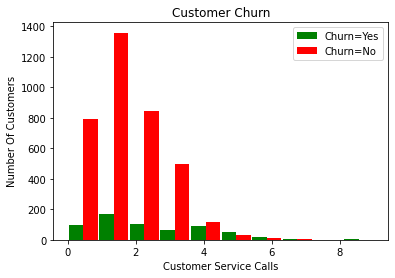

In [185]:
mc_churn_no = train[train.churn=='no'].number_customer_service_calls      
mc_churn_yes = train[train.churn=='yes'].number_customer_service_calls      

plt.xlabel("Customer Service Calls")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn")


plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

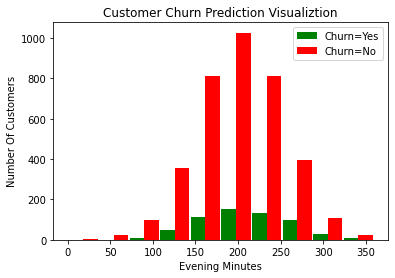

In [186]:
val = "total_eve_minutes"
mc_churn_no = train[train.churn=='no'][val]
mc_churn_yes = train[train.churn=='yes'][val]

plt.xlabel("Evening Minutes")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")


plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

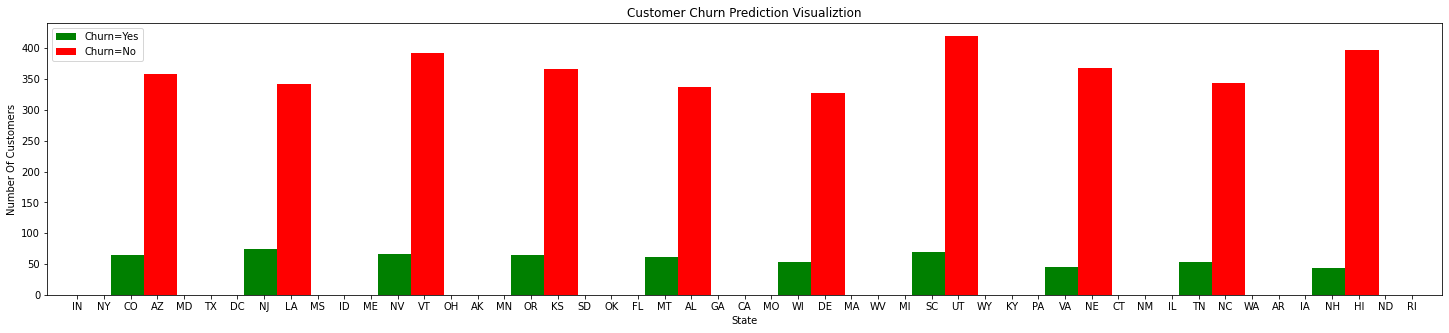

In [187]:
fig, ax = plt.subplots()
fig.set_size_inches(25,5)
mc_churn_no = train[train.churn=='no'].state      
mc_churn_yes = train[train.churn=='yes'].state      

plt.xlabel("State")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.5, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

# Data Cleaning

In [188]:
#Function to get unique values
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [189]:
print_unique_col_values(train)

state: ['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']
area_code: ['area_code_415' 'area_code_408' 'area_code_510']
international_plan: ['no' 'yes']
voice_mail_plan: ['yes' 'no']
churn: ['no' 'yes']


In [190]:
#Encode yes and no with 1 and 0
yes_no_columns = ['international_plan','voice_mail_plan','churn']
for col in yes_no_columns:
    train[col].replace({'yes': 1,'no': 0},inplace=True)

yes_no_columns_test = ['international_plan','voice_mail_plan']
for col in yes_no_columns_test:
    test[col].replace({'yes': 1,'no': 0},inplace=True)    

In [191]:
for col in train:
    print(f'{col}: {train[col].unique()}')

state: ['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']
account_length: [107 137  84  75 121 147 117 141  65  74 168  95 161  85  76  73  77 130
 111 132  57  54  20  49  12  36  78 136  98 135  34 160  64  59 142  97
  52  60  10  96  81 125 174 116 149  38  40  43 113 126 150 138 162  90
  50  82 144  46  70 128  94 155  80  99 120 108 122  93 157  63  41 193
  61  92 163  91 127 110 103 145  56 151  83 139   6 115  62 185 148  32
  68  25 179  67  19 170 106  51 118 208 131  53 105  66  35  88 123  45
 100 215  22  33  86 114  24 119 101 146 143  48 167  89 199 166 158 196
 112 209  16  39 104 129  55  44  79 159 194  87  21 133 224 140  58 109
  71  72 124 102 165  18  30 190  47 152  26  69  31 186 171  28 153 172
 169  13 189 176 156  37  27 134 243  42  23   1 200   5 178

In [192]:
#Drop state and area code columns
train.drop('state',axis='columns',inplace=True)
train.drop('area_code',axis='columns',inplace=True)

test.drop('state',axis='columns',inplace=True)
test.drop('area_code',axis='columns',inplace=True)

In [193]:
train.columns

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churn'],
      dtype='object')

In [194]:
#Scale columns

cols_to_scale = ['account_length','total_night_charge'
#, 'total_day_calls',
       #'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       #'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       #'total_day_minutes', 'total_intl_minutes', 'total_intl_calls',
       #'total_intl_charge'
       ]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train[cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
test[cols_to_scale] = scaler.fit_transform(test[cols_to_scale])


In [195]:
#Split target
X = train.drop('churn',axis='columns')
y = train['churn']

#Create train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)


In [196]:
X_train.shape

(3400, 17)

In [197]:
X_test.shape

(850, 17)

In [198]:
train.corr()

account_length  international_plan  \
account_length                       1.000000            0.027050   
international_plan                   0.027050            1.000000   
voice_mail_plan                      0.001663            0.000714   
number_vmail_messages               -0.006626            0.004808   
total_day_minutes                   -0.001612            0.040059   
total_day_calls                      0.023002            0.009776   
total_day_charge                    -0.001613            0.040061   
total_eve_minutes                   -0.010326            0.023484   
total_eve_calls                      0.005535           -0.003004   
total_eve_charge                    -0.010322            0.023479   
total_night_minutes                 -0.009916           -0.020694   
total_night_calls                   -0.001846            0.007153   
total_night_charge                  -0.009942           -0.020694   
total_intl_minutes                   0.004539            0.023815   
total_intl_calls                     0.013690            0.006956   
total_intl_charge                    0.004494            0.023799   
number_customer_service_calls        0.001002           -0.008881   
churn                                0.019378            0.259053   

                               voice_mail_plan  number_vmail_messages  \
account_length                        0.001663              -0.006626   
international_plan                    0.000714               0.004808   
voice_mail_plan                       1.000000               0.954014   
number_vmail_messages                 0.954014               1.000000   
total_day_minutes                    -0.000653               0.002000   
total_day_calls                      -0.010004              -0.006920   
total_day_charge                     -0.000658               0.001994   
total_eve_minutes                     0.011982               0.010725   
total_eve_calls                       0.000263               0.003593   
total_eve_charge                      0.011989               0.010736   
total_night_minutes                   0.017884               0.018308   
total_night_calls                     0.007872               0.001977   
total_night_charge                    0.017875               0.018300   
total_intl_minutes                    0.008098               0.005220   
total_intl_calls                     -0.005674               0.006585   
total_intl_charge                     0.008129               0.005249   
number_customer_service_calls        -0.021504              -0.015303   
churn                                -0.114643              -0.100347   

                               total_day_minutes  total_day_calls  \
account_length                         -0.001612         0.023002   
international_plan                      0.040059         0.009776   
voice_mail_plan                        -0.000653        -0.010004   
number_vmail_messages                   0.002000        -0.006920   
total_day_minutes                       1.000000         0.000747   
total_day_calls                         0.000747         1.000000   
total_day_charge                        1.000000         0.000751   
total_eve_minutes                      -0.013248         0.008661   
total_eve_calls                         0.005986         0.003739   
total_eve_charge                       -0.013258         0.008663   
total_night_minutes                     0.010049         0.002206   
total_night_calls                      -0.004812        -0.004815   
total_night_charge                      0.010036         0.002200   
total_intl_minutes                     -0.021369         0.008834   
total_intl_calls                        0.003859         0.009377   
total_intl_charge                      -0.021291         0.008909   
number_customer_service_calls          -0.002925        -0.015845   
churn                                   0.215272         0.011640   

                   

<AxesSubplot:>

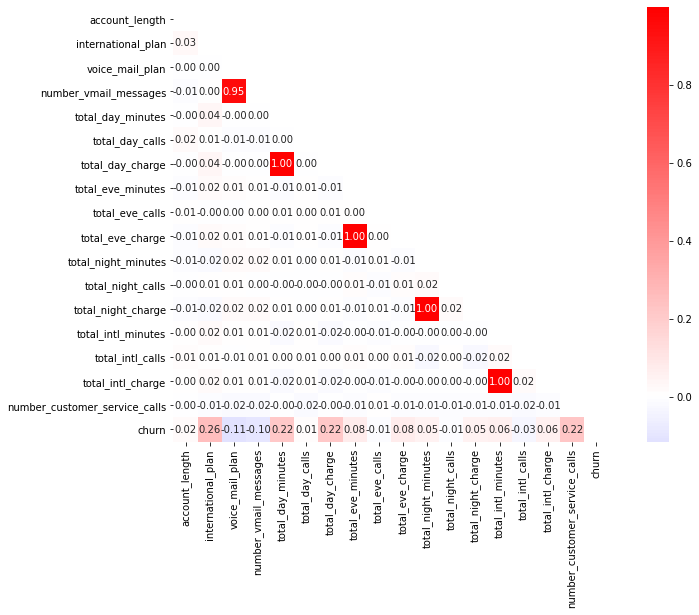

In [199]:
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
fig = plt.figure(figsize=(14,8))
sns.heatmap(corr, mask=mask, cmap=plt.cm.bwr, center=0, annot=True, fmt='.2f', square=True)

# Modeling

# Logistic Regression

In [200]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_absolute_error

In [201]:
# split data in train and test
logreg = LogisticRegression().fit(X_train, y_train)

In [202]:
# predict
pred_train = logreg.predict(X_train)
pred_test = logreg.predict(X_test)

# evaluate predictions
acc_train = accuracy_score(y_train, np.round(pred_train))
acc_test = accuracy_score(y_test, np.round(pred_test))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.8544
Test:	ACC=0.8706


In [203]:
logreg.intercept_, logreg.coef_

(array([-0.0660785]),
 array([[-2.91919110e-03,  2.83393722e-01, -3.15947461e-02,
         -2.44692842e-02,  8.66837403e-03, -9.28553422e-03,
          1.37077561e-03,  1.40489710e-03, -1.31648003e-02,
          2.07613604e-04, -1.28683592e-04, -1.43834786e-02,
         -9.37185323e-06, -3.34361421e-02, -4.71579333e-02,
         -8.98977990e-03,  3.95945487e-01]]))

In [204]:
X100 = shap.utils.sample(X_test, 100)

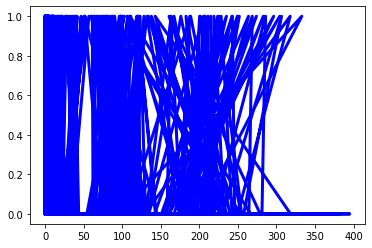

In [205]:
# Plot predictions for test set
y_pred = logreg.predict(X_test)

#plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.show()

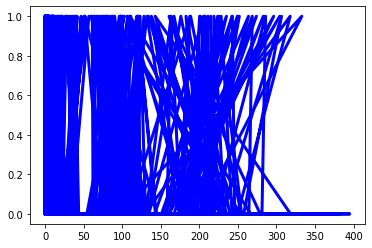

In [206]:
# Plot predictions for test set
y_pred = logreg.predict(X_test)

#plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.show()

In [207]:
y_pred = logreg.predict(test)

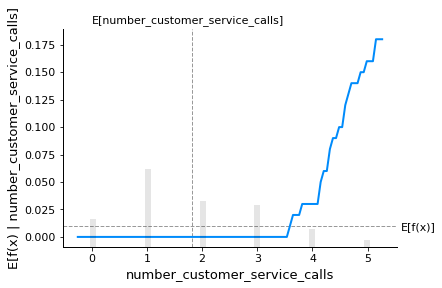

In [208]:
shap.plots.partial_dependence(
    "number_customer_service_calls", logreg.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [37]:
explainer_lr = shap.Explainer(logreg.predict, X100)
shap_values_lr = explainer_lr(X100)

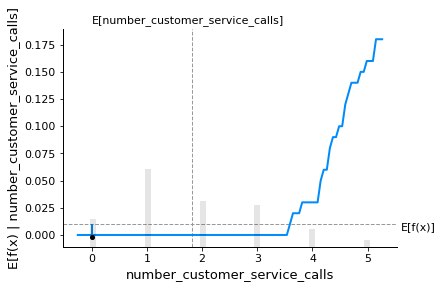

In [38]:
sample_ind = 19
shap.partial_dependence_plot(
    "number_customer_service_calls", logreg.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values_lr[sample_ind:sample_ind+1,:]
)

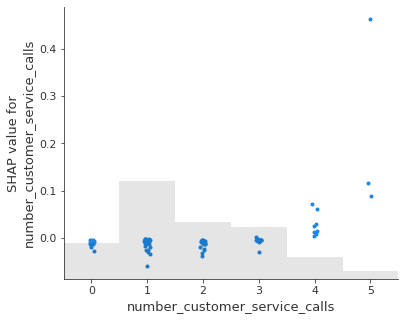

In [39]:
shap.plots.scatter(shap_values_lr[:,"number_customer_service_calls"])

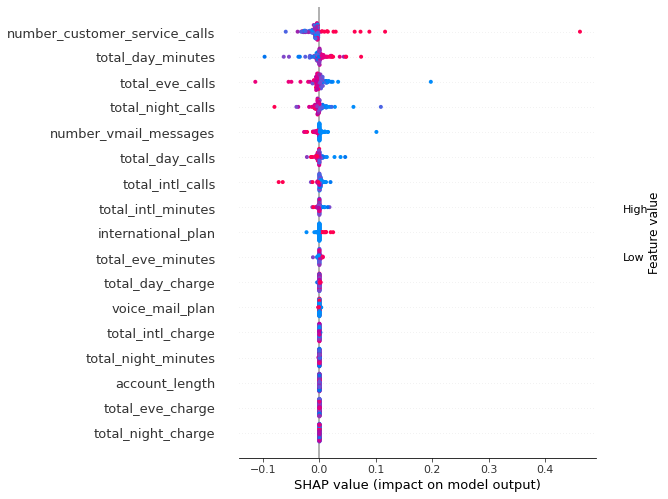

In [40]:
shap.summary_plot(shap_values_lr)

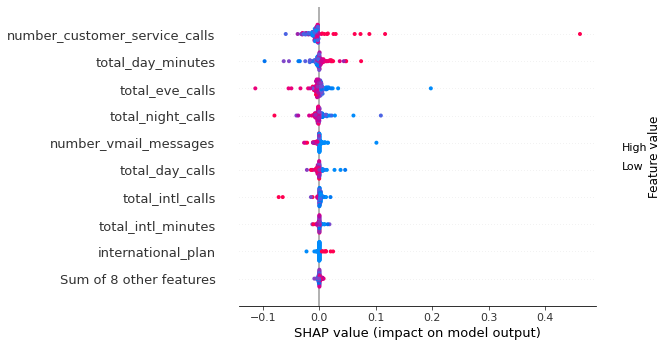

In [41]:
shap.plots.beeswarm(shap_values_lr)

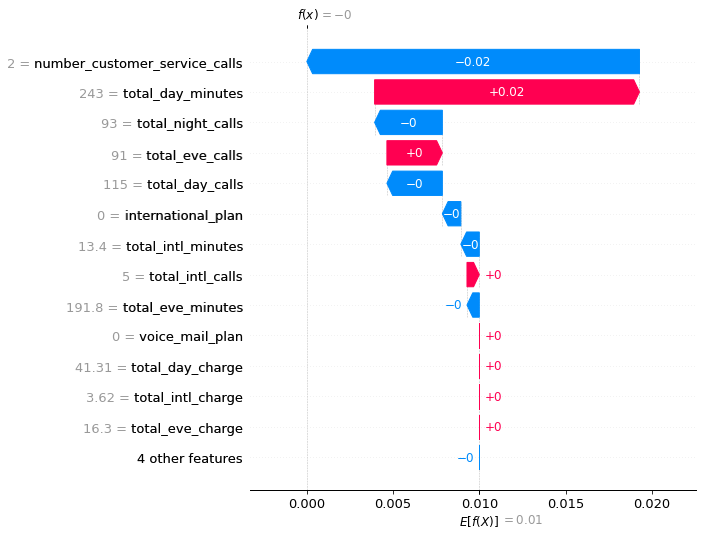

In [42]:
shap.plots.waterfall(shap_values_lr[10], max_display=14)

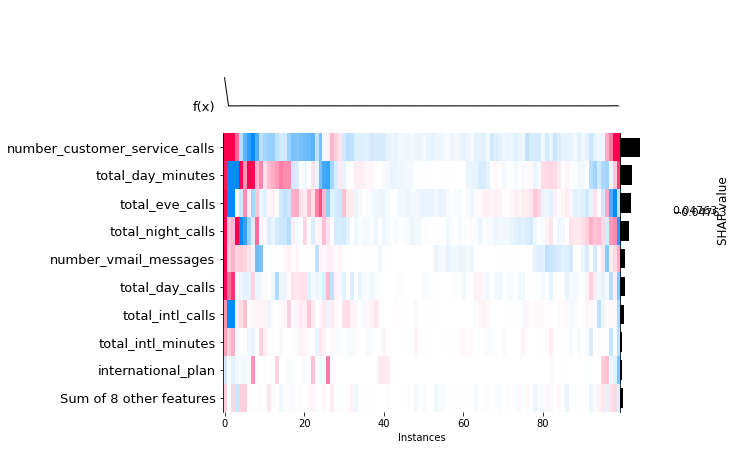

In [43]:
shap.plots.heatmap(shap_values_lr[:1000])

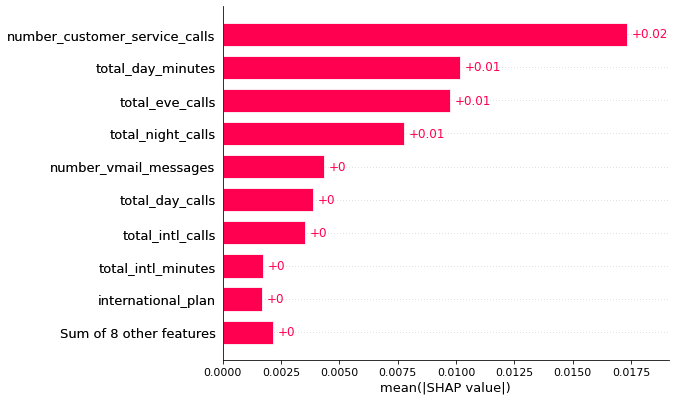

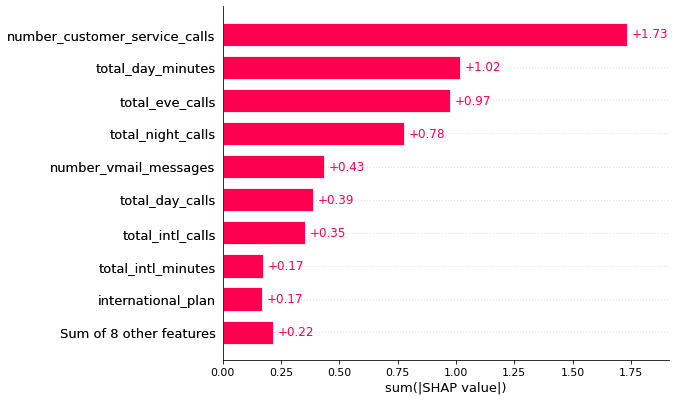

In [44]:
shap.plots.bar(shap_values_lr.abs.mean(0))
shap.plots.bar(shap_values_lr.abs.sum(0))


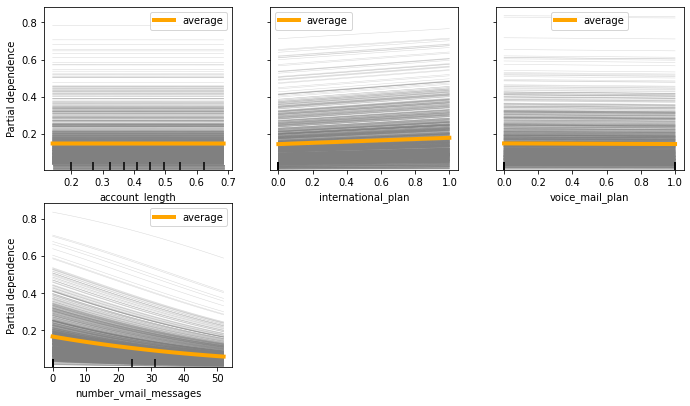

In [45]:
# humidity, windspeed, temperature
fig, ax = plt.subplots(figsize=(10, 6))
ice = PartialDependenceDisplay.from_estimator(estimator=logreg,
                        X=X_train,
                        features=[0,1,2,3],
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        # centered=True, # will be added in the future
                        ax=ax)
fig.tight_layout(pad=2.0)

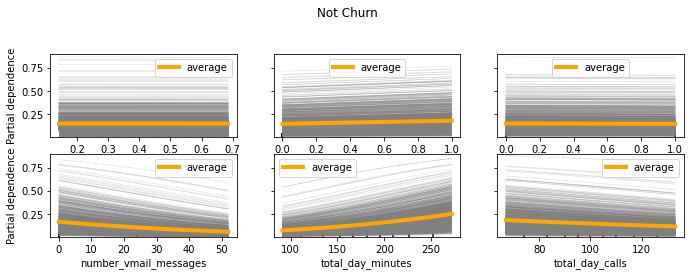

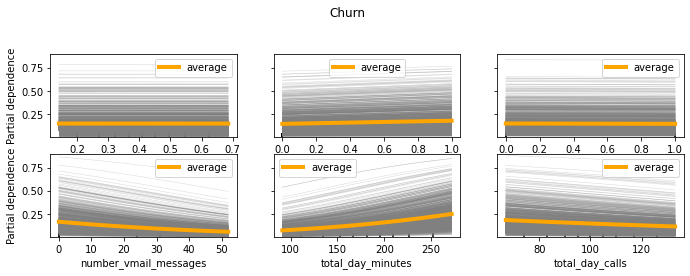

In [183]:
# target 0
fig, ax = plt.subplots(figsize=(10, 4))
ice = PartialDependenceDisplay.from_estimator(estimator=logreg,
                        X=X_train,
                        features=[0,1,2,3,4,5],
                        target=0,
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        # centered=True, # will be added in the future
                        ax=ax)
fig.suptitle("Not Churn")
fig.tight_layout(pad=2.0)

# target 1
fig1, ax1 = plt.subplots(figsize=(10, 4))
ice = PartialDependenceDisplay.from_estimator(estimator=logreg,
                        X=X_train,
                        features=[0,1,2,3,4,5],
                        target=1,
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        # centered=True, # will be added in the future
                        ax=ax1)
fig1.suptitle("Churn")
fig1.tight_layout(pad=2.0)

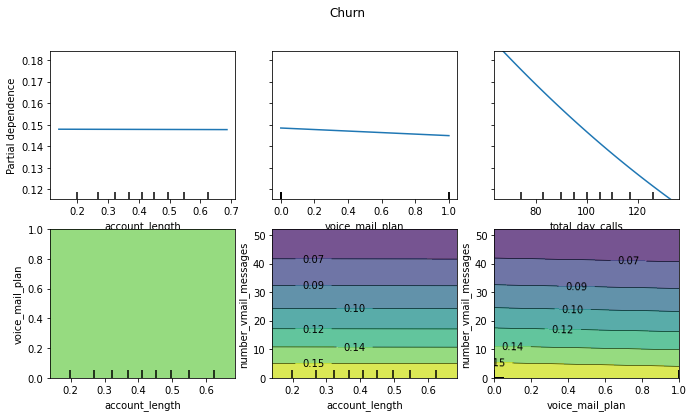

In [184]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(estimator=logreg, X=X_train, features=[0,2,5, (0,2), (0,3), (2,3)], target=1, ax=ax)
fig.suptitle("Churn")
fig.tight_layout(pad=2.0)

# Decision Tree

In [209]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [210]:
# define model
tree = DecisionTreeClassifier(max_depth=5, random_state=42)

# fit model
tree = tree.fit(X_train, y_train)

In [211]:

# predict probabilities
pred_train = tree.predict_proba(X_train)
pred_test = tree.predict_proba(X_test)

# evaluate predictions
acc_train = accuracy_score(y_train, np.argmax(pred_train, axis=1))
acc_test = accuracy_score(y_test, np.argmax(pred_test, axis=1))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9497
Test:	ACC=0.9294


In [212]:
fi = pd.DataFrame(tree.feature_importances_, index=X_train.columns, columns=["Feature importance"])
fi

Feature importance
account_length                           0.003591
international_plan                       0.077307
voice_mail_plan                          0.000000
number_vmail_messages                    0.078987
total_day_minutes                        0.103179
total_day_calls                          0.000000
total_day_charge                         0.239549
total_eve_minutes                        0.042715
total_eve_calls                          0.000000
total_eve_charge                         0.081076
total_night_minutes                      0.014847
total_night_calls                        0.000000
total_night_charge                       0.000000
total_intl_minutes                       0.110327
total_intl_calls                         0.102610
total_intl_charge                        0.000000
number_customer_service_calls            0.145812

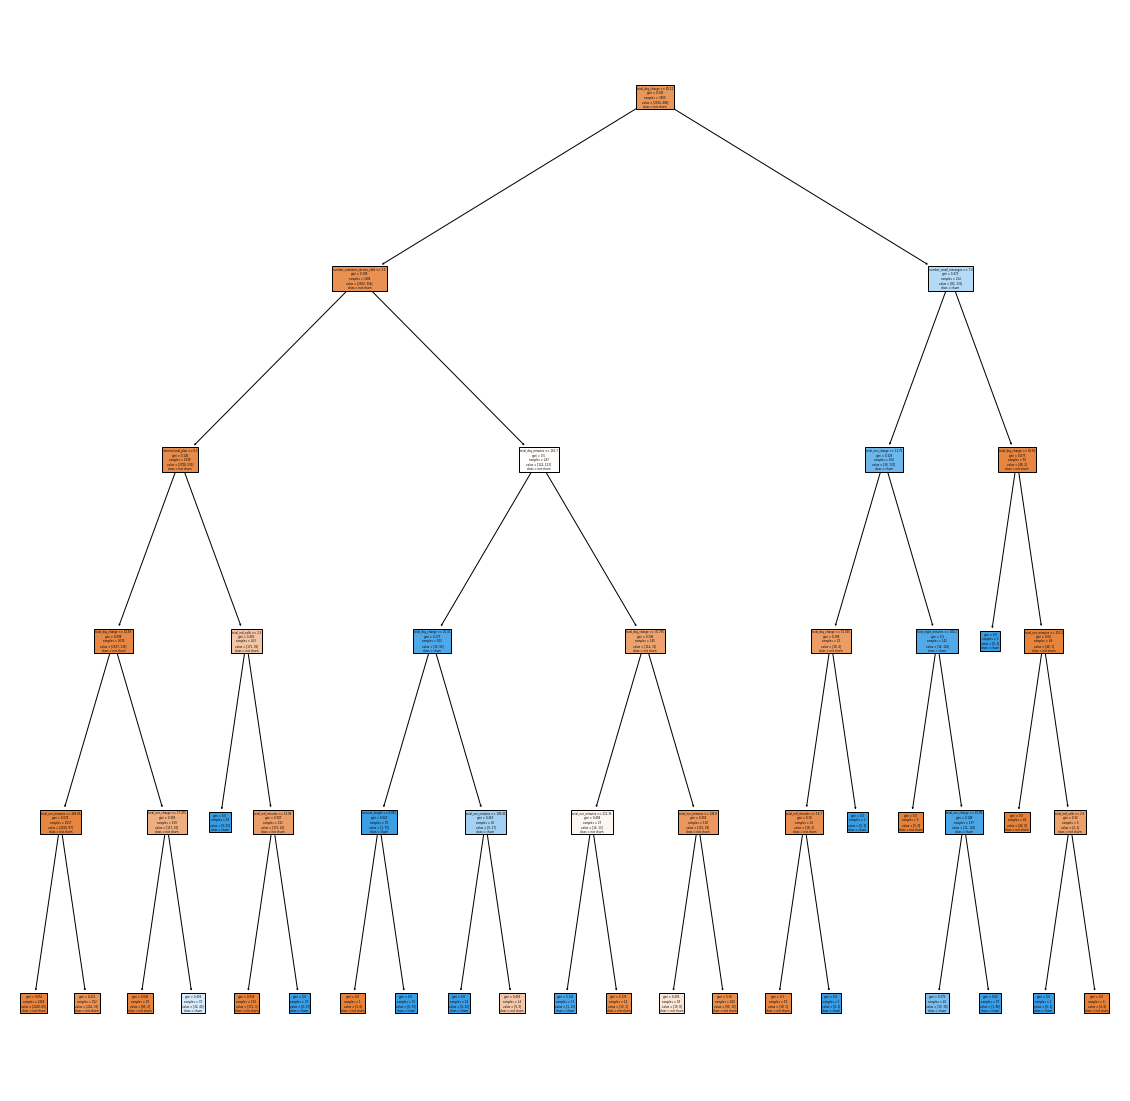

In [189]:
churn = {0:"not churn", 1:"churn"}

fig = plt.figure(figsize=(20,20))
tree_plot = plot_tree(tree, feature_names=X_train.columns, class_names=list(churn.values()), filled=True)
plt.show()

### Partial Dependence Plots

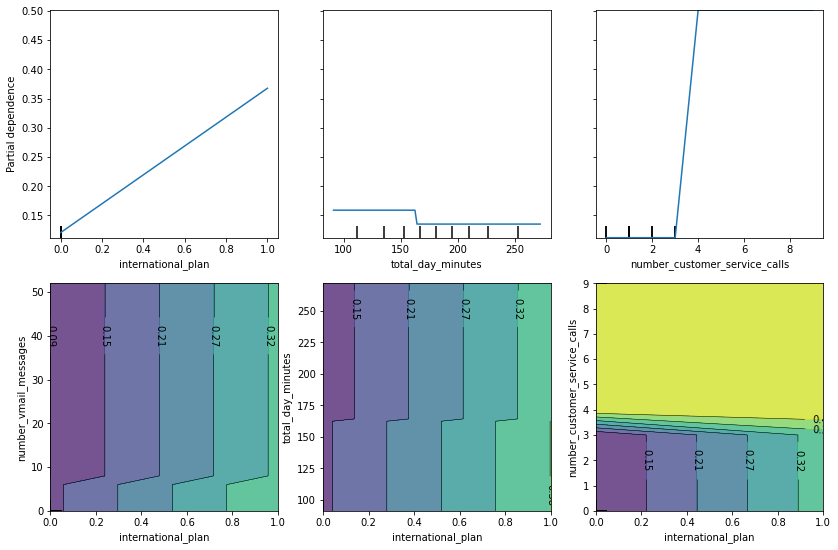

In [190]:
fig, ax = plt.subplots(figsize=(12,8))
PartialDependenceDisplay.from_estimator(estimator=tree, X=X_train, features=[1, 4,16, (1,3),(1,4),(1,16)],ax=ax)
fig.tight_layout(pad=2.0)

### ICE Plots

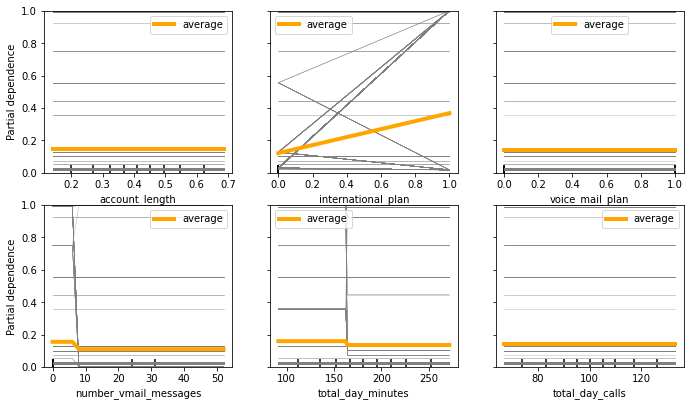

In [191]:
fig, ax = plt.subplots(figsize=(10, 6))
ice = PartialDependenceDisplay.from_estimator(estimator=tree,
                        X=X_train,
                        features=[0, 1, 2, 3, 4, 5],
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        ax=ax)
fig.tight_layout(pad=2.0)

### Ale Plots

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.11853


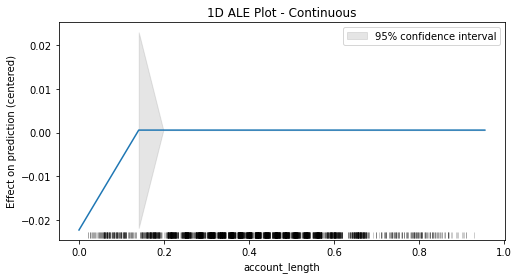

In [192]:
# ALE plot 1D (ALE from PyALE)
ale_account_length = ale(
    X=X_train,
    model=tree,
    feature=["account_length"],
    include_CI=True,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.11853


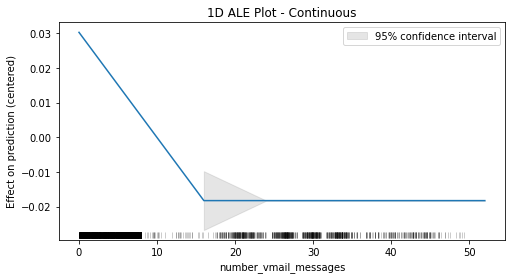

In [193]:
# ALE plot 1D (ALE from PyALE)
ale_number_vmail_messages = ale(
    X=X_train,
    model=tree,
    feature=["number_vmail_messages"],
    include_CI=True,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.11853


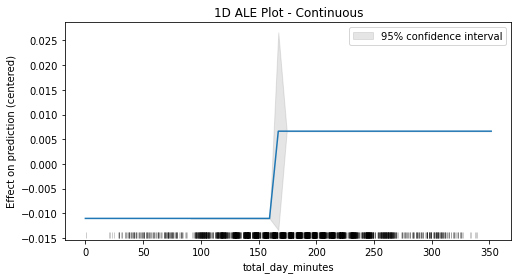

In [194]:
# ALE plot 1D (ALE from PyALE)
ale_total_day_minutes = ale(
    X=X_train,
    model=tree,
    feature=["total_day_minutes"],
    include_CI=True,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.11853


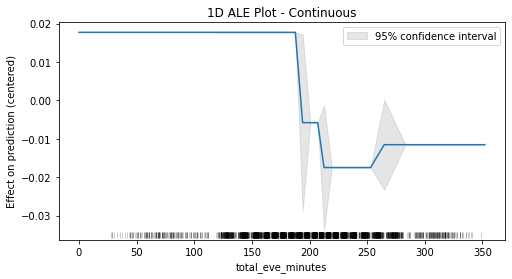

In [195]:
# ALE plot 1D (ALE from PyALE)
ale_total_eve_minutes = ale(
    X=X_train,
    model=tree,
    feature=["total_eve_minutes"],
    include_CI=True,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.11853


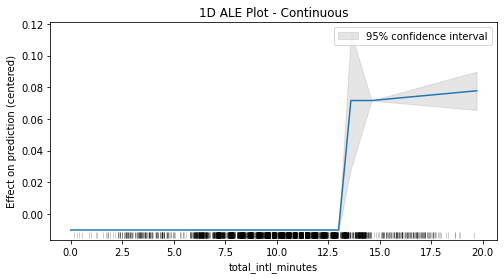

In [196]:
# ALE plot 1D (ALE from PyALE)
ale_total_intl_minutes = ale(
    X=X_train,
    model=tree,
    feature=["total_intl_minutes"],
    include_CI=True,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Discrete feature detected.


Mean response: 0.11853


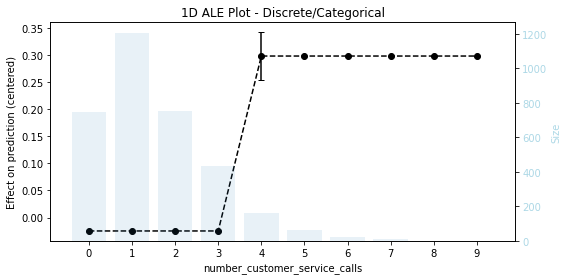

In [197]:
# ALE plot 1D (ALE from PyALE)
ale_number_customer_service_calls = ale(
    X=X_train,
    model=tree,
    feature=["number_customer_service_calls"],
    include_CI=True,
    print_meanres=True
)

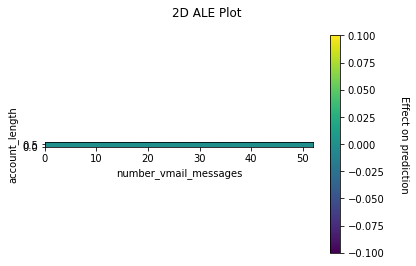

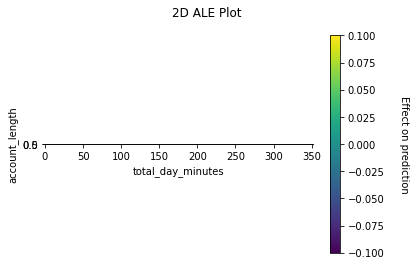

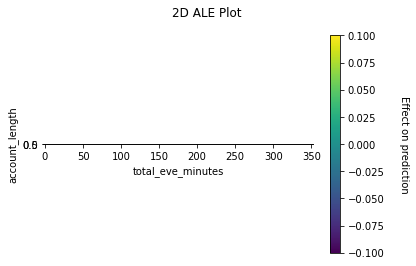

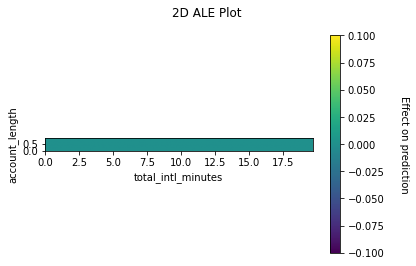

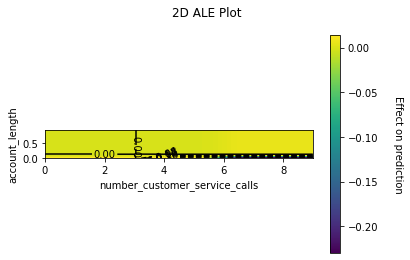

In [198]:
# ALE plot 2D

ale_al_nvm = ale(
    X=X_train,
    model=tree,
    feature=["account_length", "number_vmail_messages"], 
    contour=True,
    target=1)

# ALE plot 2D

ale_al_tdm = ale(
    X=X_train,
    model=tree,
    feature=["account_length", "total_day_minutes"], 
    contour=True,
    target=1)

ale_al_tem = ale(
    X=X_train,
    model=tree,
    feature=["account_length", "total_eve_minutes"], 
    contour=True,
    target=1)

ale_al_tim = ale(
    X=X_train,
    model=tree,
    feature=["account_length", "total_intl_minutes"], 
    contour=True,
    target=1)

ale_al_ncsc = ale(
    X=X_train,
    model=tree,
    feature=["account_length", "number_customer_service_calls"], 
    contour=True,
    target=1)

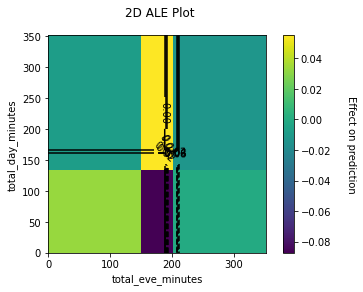

In [199]:
# ALE plot 2D

ale_tdm_tem = ale(
    X=X_train,
    model=tree,
    feature=["total_day_minutes", "total_eve_minutes"], 
    contour=True,
    target=1)

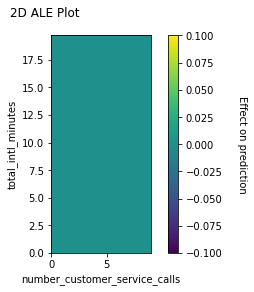

In [200]:
# ALE plot 2D

ale_tim_ncsc = ale(
    X=X_train,
    model=tree,
    feature=["total_intl_minutes", "number_customer_service_calls"], 
    contour=True,
    target=1)

### SHAP

In [201]:
# set up explainer for ".predict" method
explainer_dt = shap.Explainer(tree.predict, X_test)

# compute shap values
shap_values_dt = explainer_dt(X_test)

Permutation explainer: 851it [00:31, 18.18it/s]                         


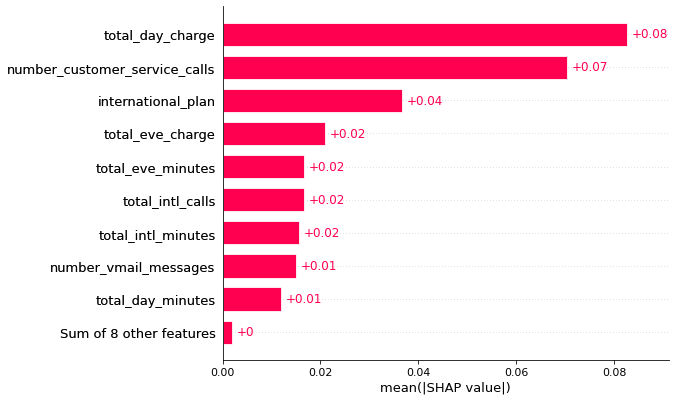

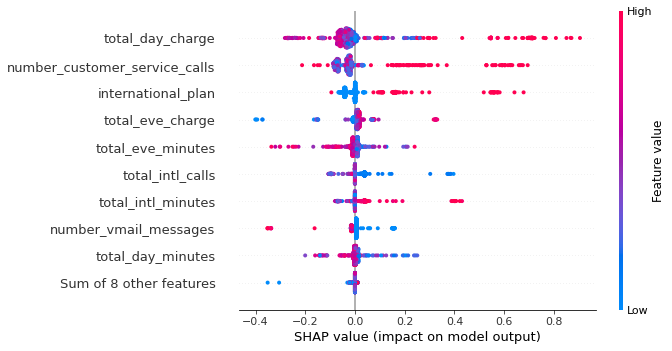

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [202]:
# bar chart
shap.plots.bar(shap_values_dt)

# individual dots for each instance
shap.plots.beeswarm(shap_values_dt)

# split population in distinct groups (uses sklearn DecisionTree)
shap.plots.bar(shap_values_dt.cohorts(2).abs.mean(0))

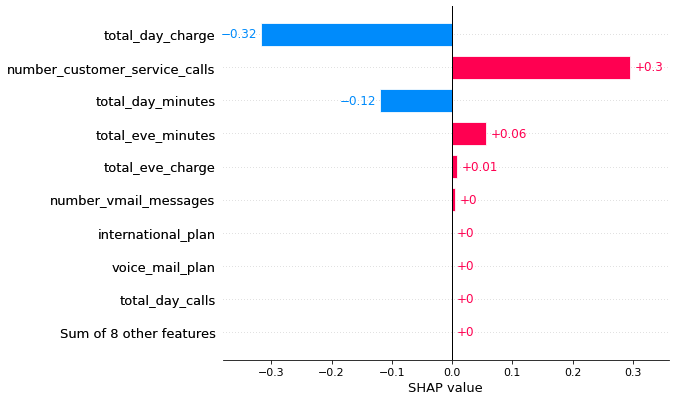

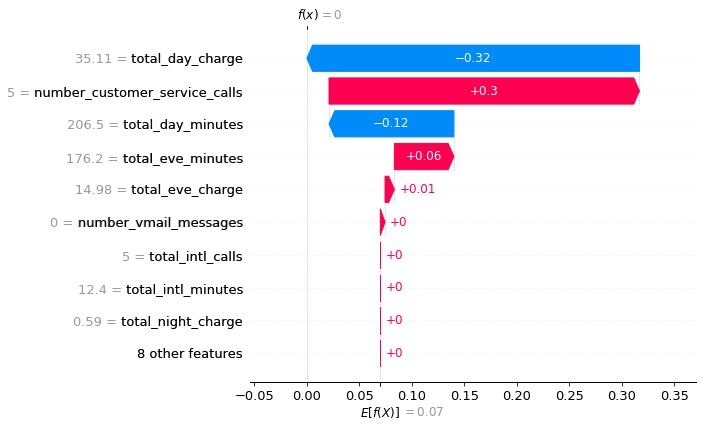

In [ ]:
# explain individual instance (local)
instance = 5

# feature importance
shap.plots.bar(shap_values_dt[instance])

# contribution to output (distinct outcomes, 0 or 1) 
# (starts with mean) (to see the outcome for each instance)
shap.plots.waterfall(shap_values_dt[instance])

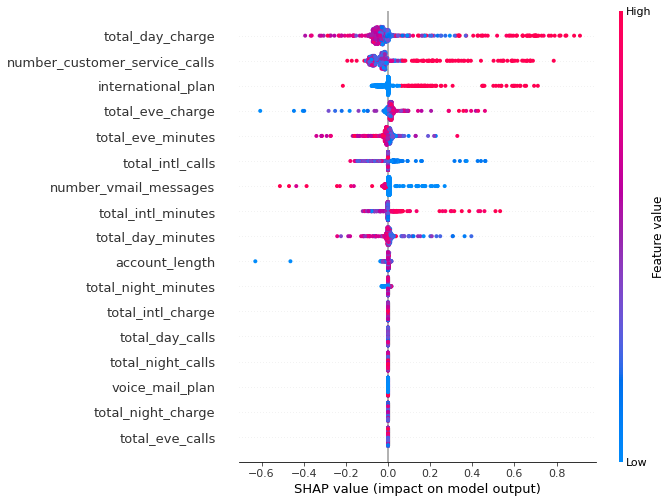

In [ ]:
shap.summary_plot(shap_values_dt, X_test, class_names=["Not churn", "Churn"])

# Random Forest

In [213]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [214]:
# predict probabilities
pred_train = rf.predict_proba(X_train)
pred_test = rf.predict_proba(X_test)

In [215]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [216]:
acc_train = accuracy_score(y_train, np.argmax(pred_train, axis=1))
acc_test = accuracy_score(y_test, np.argmax(pred_test, axis=1))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9344
Test:	ACC=0.9224


In [217]:
# Extract feature importance
print(rf.feature_importances_)

# nicely formatted
pd.DataFrame(rf.feature_importances_, index=X.columns, columns=["Feature importance"])

[0.00867537 0.08953694 0.04333705 0.04467358 0.20321148 0.01013705
 0.22598545 0.04704038 0.00695786 0.05046305 0.01766058 0.00713569
 0.01845933 0.02889989 0.03171294 0.02900201 0.13711136]


Feature importance
account_length                           0.008675
international_plan                       0.089537
voice_mail_plan                          0.043337
number_vmail_messages                    0.044674
total_day_minutes                        0.203211
total_day_calls                          0.010137
total_day_charge                         0.225985
total_eve_minutes                        0.047040
total_eve_calls                          0.006958
total_eve_charge                         0.050463
total_night_minutes                      0.017661
total_night_calls                        0.007136
total_night_charge                       0.018459
total_intl_minutes                       0.028900
total_intl_calls                         0.031713
total_intl_charge                        0.029002
number_customer_service_calls            0.137111

### Partial Dependency Plots

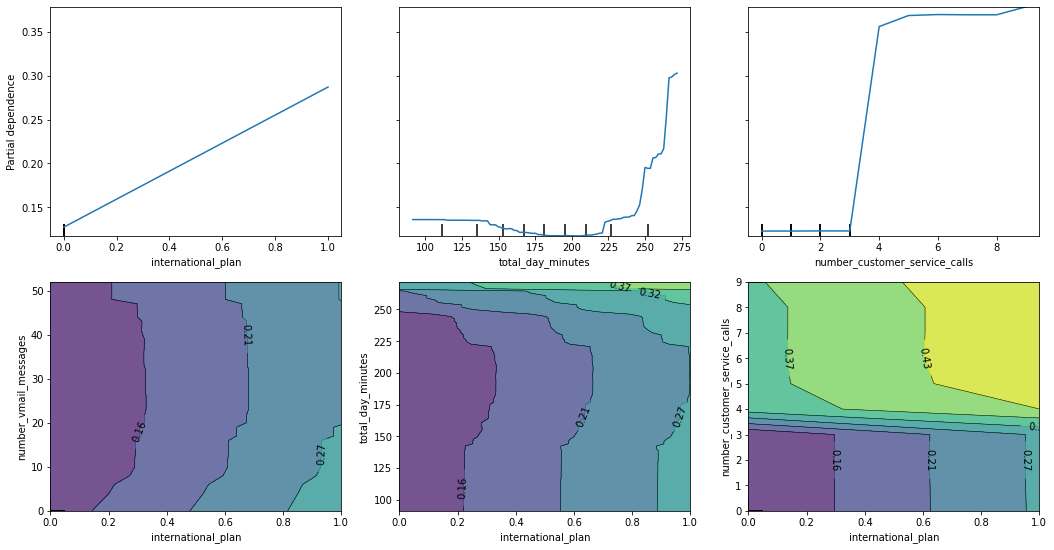

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
PartialDependenceDisplay.from_estimator(estimator=rf, X=X_train, features=[1, 4,16, (1,3),(1,4),(1,16)],ax=ax)
fig.tight_layout(pad=2.0)

### ICE Plots

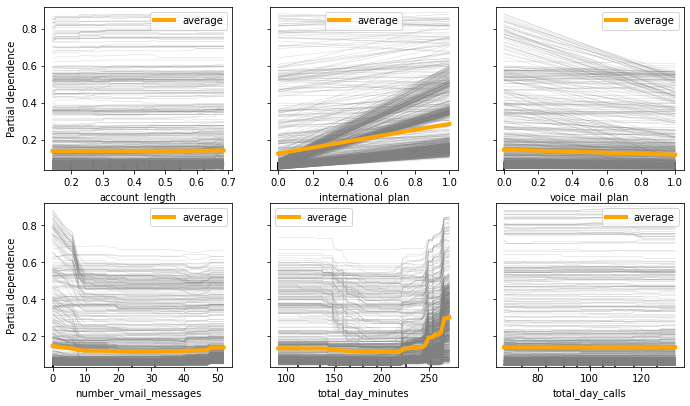

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ice = PartialDependenceDisplay.from_estimator(estimator=rf,
                        X=X_train,
                        features=[0, 1, 2, 3, 4, 5],
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        # centered=True, # will be added in the future
                        ax=ax)
fig.tight_layout(pad=2.0)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.08088


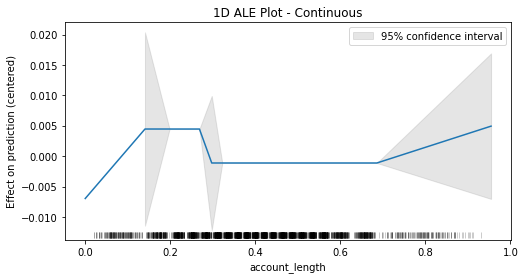

In [ ]:
# ALE plot 1D (ALE from PyALE)
ale_account_length = ale(
    X=X_train,
    model=rf,
    feature=["account_length"],
    include_CI=True,
    print_meanres=True
)

### Model 1: Artificial Neural Network

In [72]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

tf.random.set_seed(123)

model = keras.Sequential([
    keras.layers.Dense(17, input_shape=(17,), activation='relu'),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
])

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, workers=6, shuffle=2, epochs=2000)

Epoch 1/1500
107/107 [==============================] - 0s 2ms/step - loss: 0.1639 - accuracy: 0.9421
Epoch 2/1500
107/107 [==============================] - 0s 1ms/step - loss: 0.1677 - accuracy: 0.9412
Epoch 3/1500
107/107 [==============================] - 0s 1ms/step - loss: 0.1640 - accuracy: 0.9432
Epoch 4/1500
107/107 [==============================] - 0s 1ms/step - loss: 0.1681 - accuracy: 0.9432
Epoch 5/1500
107/107 [==============================] - 0s 1ms/step - loss: 0.1687 - accuracy: 0.9429
Epoch 6/1500
107/107 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.9406
Epoch 7/1500
107/107 [==============================] - 0s 2ms/step - loss: 0.1689 - accuracy: 0.9394
Epoch 8/1500
107/107 [==============================] - 0s 2ms/step - loss: 0.1744 - accuracy: 0.9376
Epoch 9/1500
107/107 [==============================] - 0s 2ms/step - loss: 0.1721 - accuracy: 0.9412
Epoch 10/1500
107/107 [==============================] - 0s 2ms/step - loss: 0.168

In [82]:
#Evaluate model
model.evaluate(X_test, y_test)

27/27 [==============================] - 0s 846us/step - loss: 0.3158 - accuracy: 0.9141


[0.3158082067966461, 0.9141176342964172]

In [83]:
scores = model.evaluate(X_test, y_test)
scores[1]*100

27/27 [==============================] - 0s 920us/step - loss: 0.3158 - accuracy: 0.9141


91.41176342964172

In [76]:
from keras.models import model_from_json
from tensorflow.keras.models import load_model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [77]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [38]:
model.evaluate(X_test, y_test)

27/27 [==============================] - 0s 1ms/step - loss: 0.2750 - accuracy: 0.8941


[0.2750088572502136, 0.8941176533699036]

In [86]:
yp = model.predict(X_test)
yp[:5]

array([[0.8142041 ],
       [0.06302664],
       [0.28039098],
       [0.01955929],
       [0.01292655]], dtype=float32)

In [87]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [88]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       738
           1       0.70      0.62      0.65       112

    accuracy                           0.91       850
   macro avg       0.82      0.79      0.80       850
weighted avg       0.91      0.91      0.91       850



Text(69.0, 0.5, 'Truth')

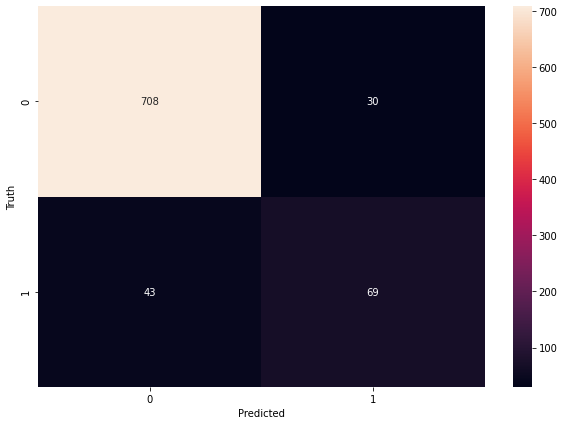

In [89]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [90]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [40]:
def base_model():

    model = keras.Sequential([
    keras.layers.Dense(17, input_shape=(17,), activation='relu'),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
])
    #opt = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

    return model

In [41]:
model_fs = KerasRegressor(build_fn=base_model)

In [42]:
model_fs.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1100, batch_size=32)

Epoch 1/1100
107/107 [==============================] - 1s 2ms/step - loss: 5.1238 - accuracy: 0.7144 - val_loss: 1.4771 - val_accuracy: 0.8282
Epoch 2/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.7606 - accuracy: 0.7947 - val_loss: 0.5306 - val_accuracy: 0.8518
Epoch 3/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.8332 - val_loss: 0.4094 - val_accuracy: 0.8494
Epoch 4/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.8435 - val_loss: 0.4289 - val_accuracy: 0.8647
Epoch 5/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.4113 - accuracy: 0.8500 - val_loss: 0.3627 - val_accuracy: 0.8718
Epoch 6/1100
107/107 [==============================] - 0s 2ms/step - loss: 0.4001 - accuracy: 0.8512 - val_loss: 0.3452 - val_accuracy: 0.8682
Epoch 7/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.4158 - accuracy: 0.8441 - val_loss: 0.3456 - val_accuracy:

In [91]:
#model_fs.evaluate(X_test, y_test)

In [356]:
perm = PermutationImportance(model_fs, random_state=1).fit(X[:100].values,y[:100].values,verbose=False)

4/4 [==============================] - 0s 1ms/step - loss: 0.6273 - accuracy: 0.8900


In [218]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

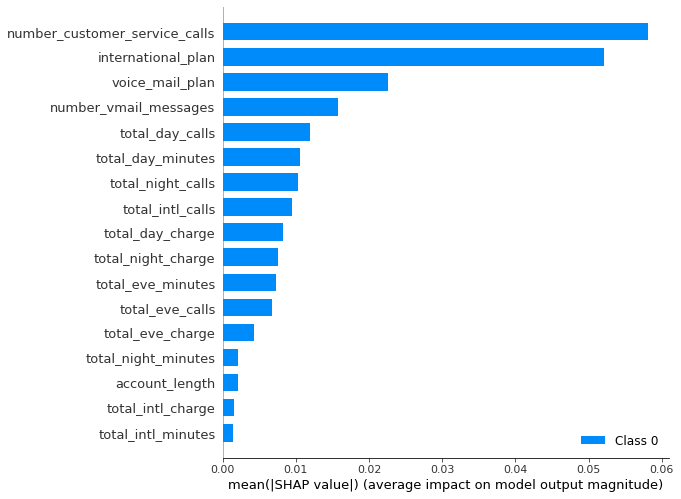

In [132]:
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.DeepExplainer(model,data=X[:500].values)
shap_values = explainer.shap_values(X.values)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

shap.summary_plot(shap_values, X, plot_type="bar")

In [135]:
# set up explainer for ".predict" method
explainer = shap.Explainer(model.predict, X_test)

# compute shap values
shap_values = explainer(X_test)

Permutation explainer: 851it [17:51,  1.27s/it]


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

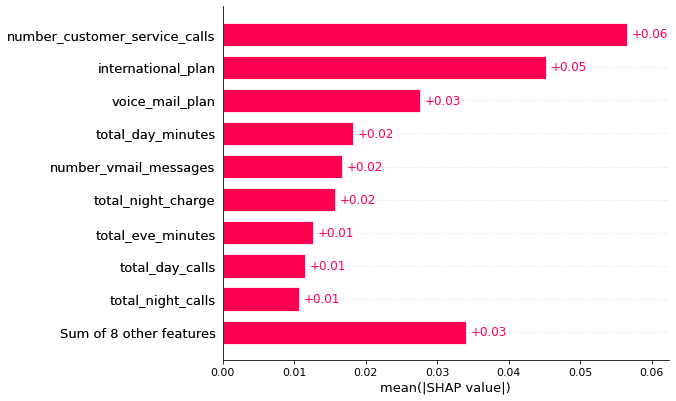

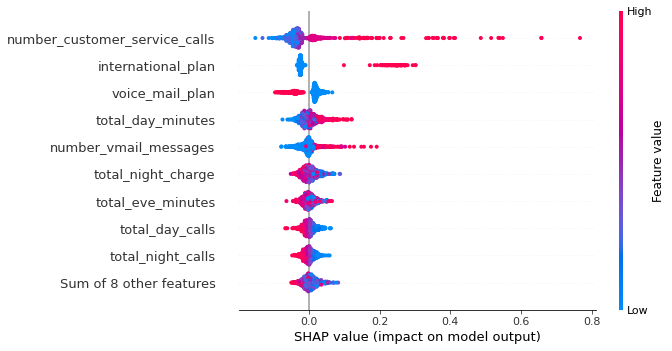

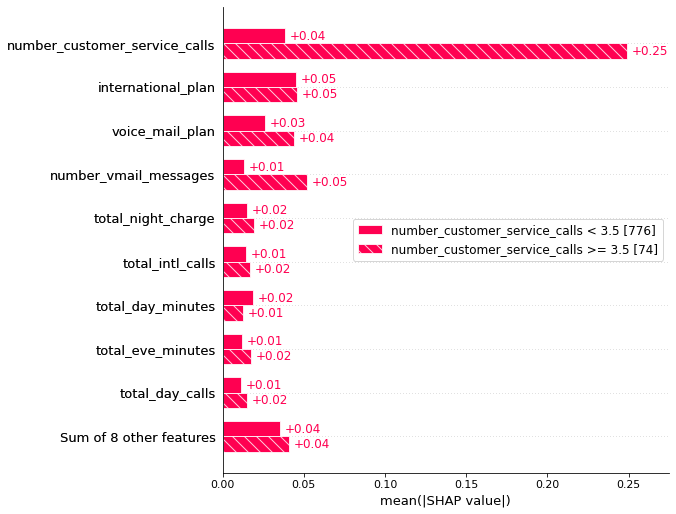

In [146]:
# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

# split population in distinct groups (uses sklearn DecisionTree)
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

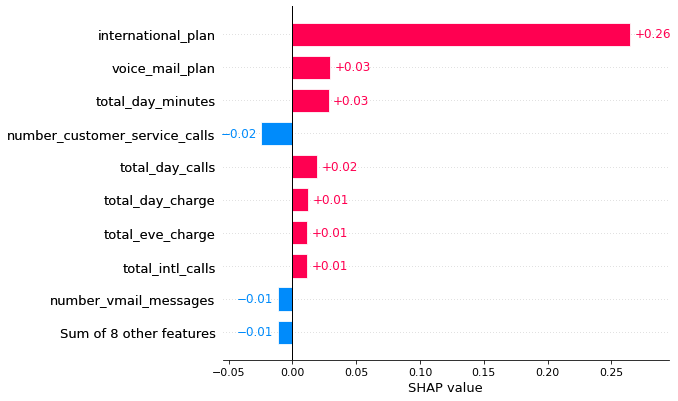

In [150]:
# explain individual instance (local)
instance = 2

# feature importance
shap.plots.bar(shap_values[instance])

In [152]:
# contribution to output (distinct outcomes, 0 or 1) 
# (starts with mean) (to see the outcome for each instance)
#shap.plots.waterfall(shap_values[instance])

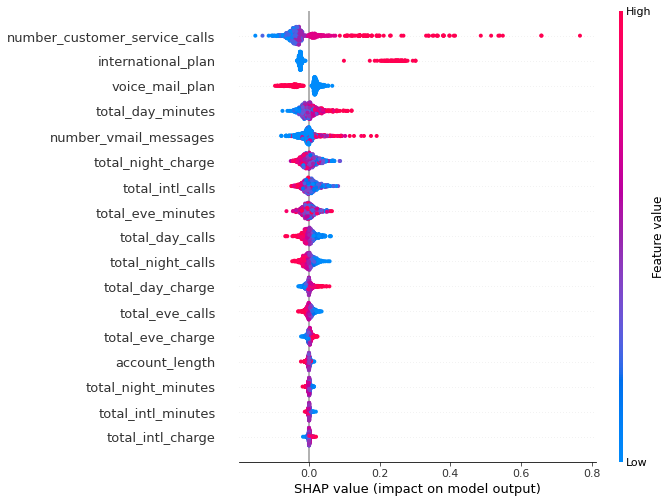

In [155]:
shap.summary_plot(shap_values, X_test, class_names=["Not churn", "Churn"])

In [158]:
train.columns

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churn'],
      dtype='object')

In [219]:
variables = ['account_length','international_plan', 
       'voice_mail_plan', 'total_day_charge',
        'number_customer_service_calls']

In [220]:
train[variables]

account_length  international_plan  voice_mail_plan  total_day_charge  \
0           0.438017                   0                1             27.47   
1           0.561983                   0                0             41.38   
2           0.342975                   1                0             50.90   
3           0.305785                   1                0             28.34   
4           0.495868                   0                1             37.09   
...              ...                 ...              ...               ...   
4245        0.338843                   0                0             32.01   
4246        0.297521                   0                0             30.24   
4247        0.305785                   0                0             29.02   
4248        0.202479                   0                1             40.07   
4249        0.351240                   0                1             22.00   

      number_customer_service_calls  
0                                 1  
1                                 0  
2                                 2  
3                                 3  
4                                 3  
...                             ...  
4245                              0  
4246                              3  
4247                              1  
4248                              2  
4249                              0  

[4250 rows x 5 columns]

# Adjust the model

In [206]:
import tensorflow as tf
from tensorflow import keras


model_adj = keras.Sequential([
    keras.layers.Dense(17, input_shape=(5,), activation='relu'),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )
])

opt = keras.optimizers.Adam(learning_rate=0.01)

model_adj.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [213]:
model_adj.fit(X_train[variables], y_train, workers=6, shuffle=2, epochs=1100)

Epoch 1/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2346 - accuracy: 0.9074
Epoch 2/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2346 - accuracy: 0.9091
Epoch 3/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2345 - accuracy: 0.9109
Epoch 4/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2335 - accuracy: 0.9106
Epoch 5/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2367 - accuracy: 0.9097
Epoch 6/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2340 - accuracy: 0.9100
Epoch 7/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2339 - accuracy: 0.9100
Epoch 8/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.9112
Epoch 9/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.2333 - accuracy: 0.9085
Epoch 10/1100
107/107 [==============================] - 0s 1ms/step - loss: 0.233

In [221]:
#from sklearn.utils import validation
#validation.check_is_fitted(estimator=model_adj)

In [211]:
model_adj.evaluate(X_train[variables], y_train)

107/107 [==============================] - 0s 792us/step - loss: 0.2320 - accuracy: 0.9112


[0.2320033460855484, 0.9111764430999756]

In [165]:
model_adj.evaluate(X_test[variables], y_test)

27/27 [==============================] - 0s 925us/step - loss: 0.2427 - accuracy: 0.9012


[0.24272118508815765, 0.9011764526367188]

In [172]:
#Load saved model
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model_adj.h5")
# print("Saved model to disk")

# Predict on actual test data

## Neural Network

In [105]:
seq_predictions=model_adj.predict(test[variables])
seq_predictions=np.transpose(seq_predictions)[0]  # transformation to get (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, seq_predictions))

### Add predictions to test data

In [203]:
test_predicted = test
test_predicted["churn"] = seq_predictions

### Shap Plots for adjusted model - Ran on actual test data

In [171]:
# set up explainer for ".predict" method
explainer = shap.Explainer(model_adj.predict, test_predicted[variables])
# compute shap values
shap_values = explainer(test_predicted[variables])

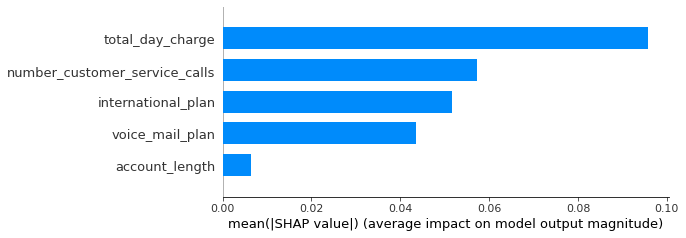

In [196]:
shap.summary_plot(shap_values, test_predicted[variables], plot_type="bar")

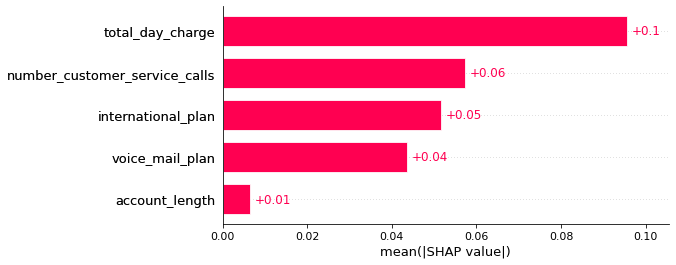

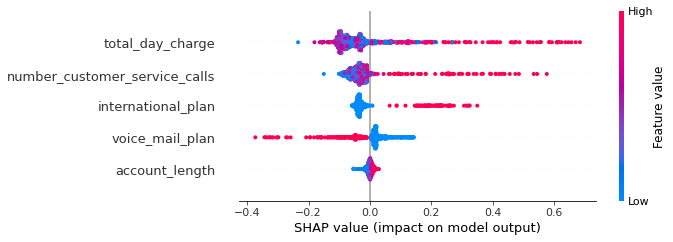

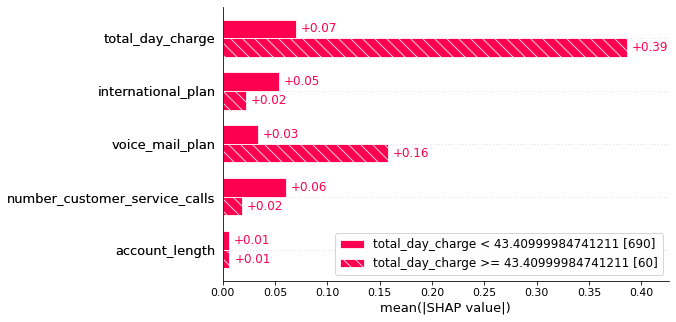

In [197]:
# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

# split population in distinct groups (uses sklearn DecisionTree)
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

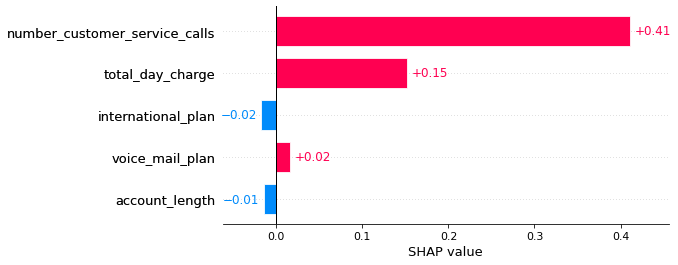

In [198]:
# explain individual instance (local)
instance = 2

# feature importance
shap.plots.bar(shap_values[instance])

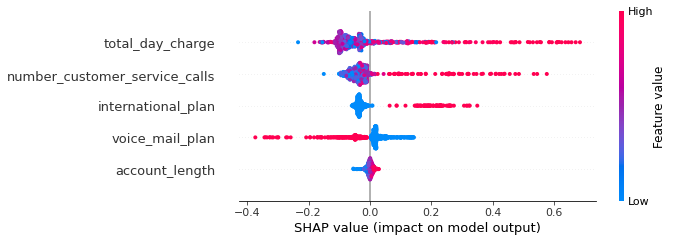

In [200]:
shap.summary_plot(shap_values, test_predicted[variables], class_names=["Not churn", "Churn"])

### PDP

In [124]:
variables

['account_length',
 'international_plan',
 'voice_mail_plan',
 'total_day_charge',
 'number_customer_service_calls']

In [125]:
test_predicted[['account_length',
 'international_plan',
 'voice_mail_plan',
 'total_day_charge',
 'number_customer_service_calls']]

account_length  international_plan  voice_mail_plan  total_day_charge  \
0          0.535865                   0                1             45.07   
1          0.493671                   1                0             37.98   
2          0.257384                   0                0             20.52   
3          0.388186                   0                0             32.42   
4          0.729958                   0                0             21.13   
..              ...                 ...              ...               ...   
745        0.544304                   0                0             20.30   
746        0.303797                   0                0             30.12   
747        0.637131                   0                0             31.31   
748        0.253165                   0                0             23.90   
749        0.455696                   0                0             32.10   

     number_customer_service_calls  
0                                1  
1                                0  
2                                4  
3                                3  
4                                3  
..                             ...  
745                              0  
746                              3  
747                              3  
748                              1  
749                              0  

[750 rows x 5 columns]

### DT with feature selection

In [48]:
# define model
tree = DecisionTreeClassifier(max_depth=5, random_state=42)

In [51]:
# fit model
tree = tree.fit(X_train[variables], y_train)

In [53]:
# predict probabilities
pred_train = tree.predict_proba(X_train[variables])
pred_test = tree.predict_proba(X_test[variables])

# evaluate predictions
acc_train = accuracy_score(y_train, np.argmax(pred_train, axis=1))
acc_test = accuracy_score(y_test, np.argmax(pred_test, axis=1))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9162
Test:	ACC=0.8882


### Random forest with feature selection

In [223]:
rf_adj = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_adj.fit(X_train[variables],y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [224]:
#Random Forest
pred_train = rf_adj.predict_proba(X_train[variables])
pred_test = rf_adj.predict_proba(X_test[variables])

In [225]:
# evaluate predictions
acc_train = accuracy_score(y_train, np.argmax(pred_train, axis=1))
acc_test = accuracy_score(y_test, np.argmax(pred_test, axis=1))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9121
Test:	ACC=0.9000


In [226]:
rf_pred_c = rf_adj.predict(test[variables])

In [227]:
rf_predicted_dataset  = test

In [228]:
test["churn"] = rf_pred_c

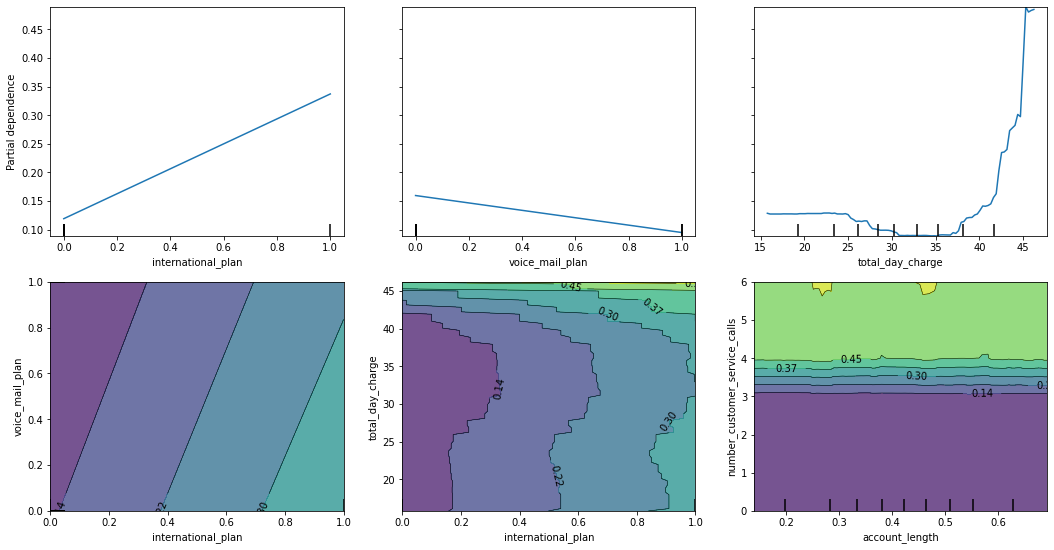

In [229]:
fig, ax = plt.subplots(figsize=(15,8))
PartialDependenceDisplay.from_estimator(estimator=rf_adj, X=test[variables], features=[1,2,3,(1,2), (1,3),(0,4)],ax=ax)
fig.tight_layout(pad=2.0)

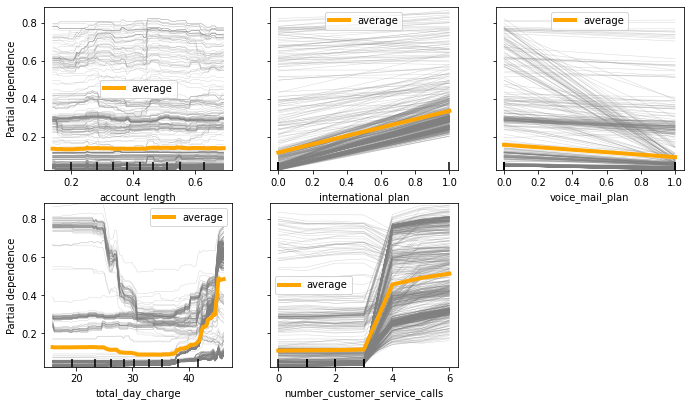

In [230]:
fig, ax = plt.subplots(figsize=(10, 6))
ice = PartialDependenceDisplay.from_estimator(estimator=rf_adj,
                        X=test[variables],
                        features=[0, 1, 2, 3, 4],
                        kind="both",
                        ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                        pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
                        # centered=True, # will be added in the future
                        ax=ax)
fig.tight_layout(pad=2.0)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.07733


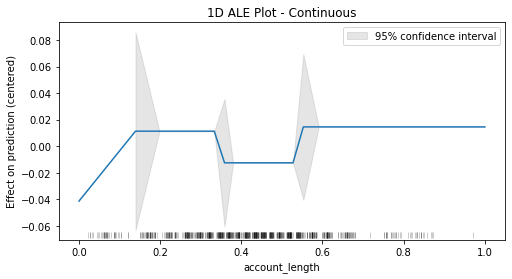

In [231]:
# ALE plot 1D (ALE from PyALE)
ale_account_length = ale(
    X=test[variables],
    model=rf_adj,
    feature=["account_length"],
    include_CI=True,
    print_meanres=True
)

In [232]:
test[variables]

account_length  international_plan  voice_mail_plan  total_day_charge  \
0          0.535865                   0                1             45.07   
1          0.493671                   1                0             37.98   
2          0.257384                   0                0             20.52   
3          0.388186                   0                0             32.42   
4          0.729958                   0                0             21.13   
..              ...                 ...              ...               ...   
745        0.544304                   0                0             20.30   
746        0.303797                   0                0             30.12   
747        0.637131                   0                0             31.31   
748        0.253165                   0                0             23.90   
749        0.455696                   0                0             32.10   

     number_customer_service_calls  
0                                1  
1                                0  
2                                4  
3                                3  
4                                3  
..                             ...  
745                              0  
746                              3  
747                              3  
748                              1  
749                              0  

[750 rows x 5 columns]

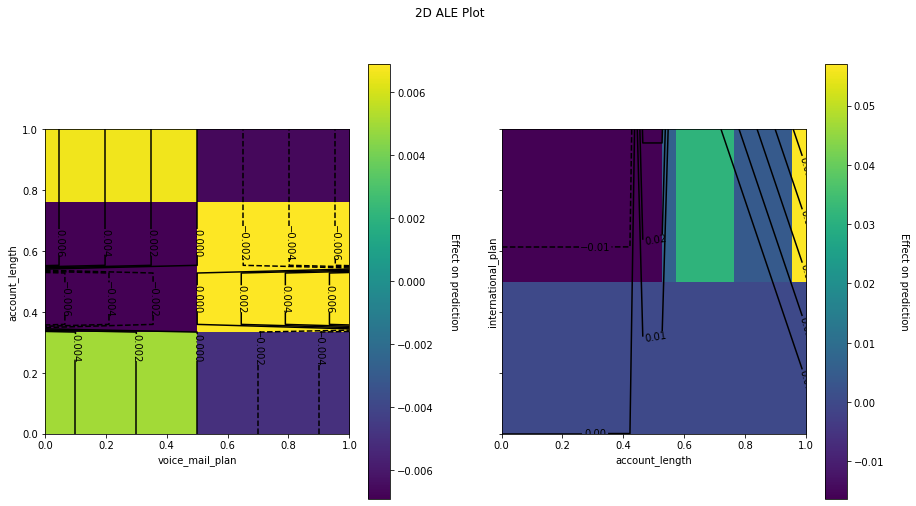

In [233]:
fig, axs = plt.subplots(1,2,figsize=(15, 8), sharey=True)
ale_al_nvm = ale(
    X=test[variables],
    model=rf_adj,
    feature=["account_length", "voice_mail_plan"], 
    contour=True,
    fig=fig,
    ax=axs[0])

ale_al_nvm = ale(
    X=test[variables],
    model=rf_adj,
    feature=["international_plan", "account_length"], 
    contour=True,
    fig=fig,
    ax=axs[1])

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Discrete feature detected.


Mean response: 0.07733
Mean response: 0.07733


invalid value encountered in reduce
invalid value encountered in reduce


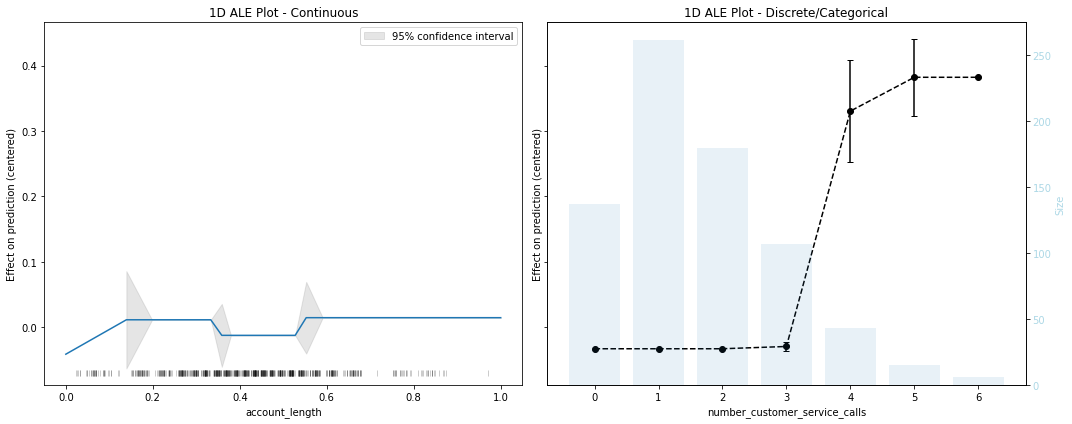

In [234]:
fig, axs = plt.subplots(1,2,figsize=(15, 6), sharey=True)
fig.tight_layout(pad=3)
ale_acc_lth_dt = ale(
    X=test[variables],
    model=rf_adj,
    feature=["account_length"],
    include_CI=True,
    fig=fig,
    ax=axs[0], print_meanres=True)

ale_acc_lth_dt = ale(
    X=test[variables],
    model=rf_adj,
    feature=["number_customer_service_calls"],
    include_CI=True,
    fig=fig,
    ax=axs[1], print_meanres=True)

In [280]:
shap_df = test[variables][:500]

In [281]:
explainer_rf_adj = shap.KernelExplainer(rf_adj.predict_proba, shap_df)
shap_values_rf_adj = explainer_rf_adj.shap_values(shap_df)

shap:WARNING: Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 500/500 [02:22<00:00,  3.51it/s]


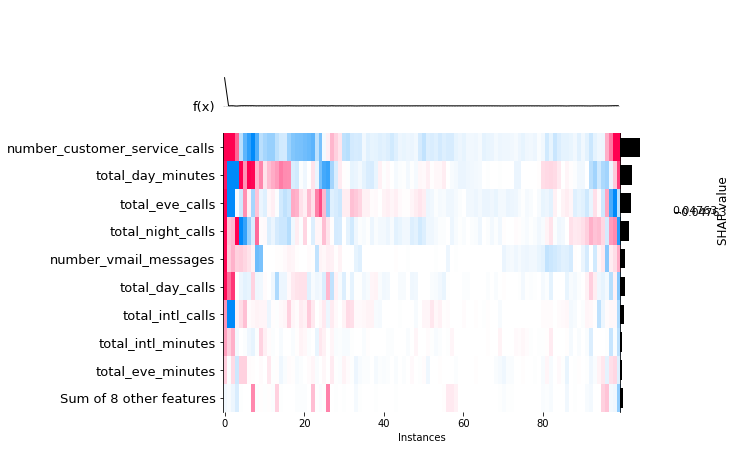

In [237]:
#shap.plots.heatmap(shap_values_lr[:1000])

In [282]:
shap.initjs()
shap.force_plot(explainer_rf_adj.expected_value[1], shap_values_rf_adj[1], shap_df)

In [273]:
subset_int_plan = test[test["international_plan"]==1][variables]

In [274]:
sub_pred = rf_adj.predict(subset_int_plan)

In [275]:
subset_int_plan["churn"] = sub_pred

In [276]:
subset_int_plan

account_length  international_plan  voice_mail_plan  total_day_charge  \
1          0.493671                   1                0             37.98   
26         0.345992                   1                0             46.16   
37         0.291139                   1                0             38.54   
54         0.535865                   1                1             38.00   
60         0.518987                   1                0             41.58   
..              ...                 ...              ...               ...   
691        0.662447                   1                0             34.00   
692        0.189873                   1                1             29.05   
697        0.426160                   1                0             13.33   
698        0.569620                   1                1             27.25   
731        0.215190                   1                1             35.28   

     number_customer_service_calls  churn  
1                                0      0  
26                               1      1  
37                               2      0  
54                               2      0  
60                               1      0  
..                             ...    ...  
691                              0      0  
692                              2      0  
697                              0      0  
698                              0      0  
731                              2      0  

[77 rows x 6 columns]

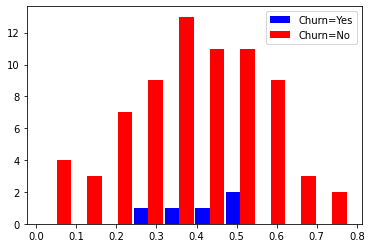

In [277]:
tenure_churn_no = subset_int_plan[subset_int_plan.churn==0].account_length
tenure_churn_yes = subset_int_plan[subset_int_plan.churn==1].account_length

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['blue','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

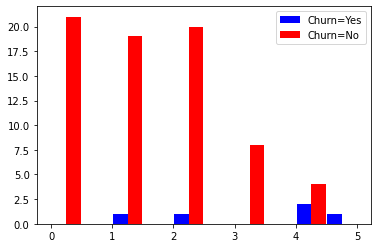

In [278]:
tenure_churn_no = subset_int_plan[subset_int_plan.churn==0].number_customer_service_calls
tenure_churn_yes = subset_int_plan[subset_int_plan.churn==1].number_customer_service_calls


plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['blue','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

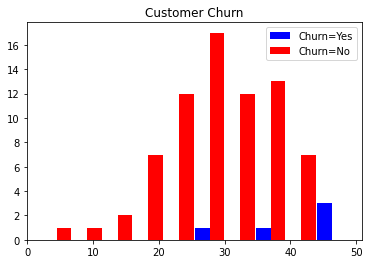

In [279]:
tenure_churn_no = subset_int_plan[subset_int_plan.churn==0].total_day_charge
tenure_churn_yes = subset_int_plan[subset_int_plan.churn==1].total_day_charge

plt.title("Customer Churn")


plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['blue','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

In [ ]:
shap.initjs()